##Simple MNIST convnet

In [10]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Prepare the data

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Build the model

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Train the model

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Evaluate the trained model

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

## RNN Example - Kafka text

In [16]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys
import io

Get the data

In [17]:
!wget -O kafka_Metamorphosis.txt https://www.gutenberg.org/files/5200/5200-0.txt

--2023-02-21 11:38:16--  https://www.gutenberg.org/files/5200/5200-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142017 (139K) [text/plain]
Saving to: ‘kafka_Metamorphosis.txt’

kafka_Metamorphosis 100%[===================>] 138.69K   457KB/s    in 0.3s    

2023-02-21 11:38:17 (457 KB/s) - ‘kafka_Metamorphosis.txt’ saved [142017/142017]



In [18]:
text = open('kafka_Metamorphosis.txt', 'r').read().lower()
print('text length', len(text))

text length 138408


In [ ]:
print(text[:1000])

Map chars to integers

In [ ]:
chars = sorted(list(set(text)))
print('total chars: ', len(chars))

In [21]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Split up into subsequences

In [22]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 46123


In [23]:
print(sentences[:3])
print(next_chars[:3])

['\ufeffthe project gutenberg ebook of metamorp', 'e project gutenberg ebook of metamorphos', 'roject gutenberg ebook of metamorphosis,']
['h', 'i', ' ']


In [24]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

<ipython-input-24-b8405c8d7c41>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
<ipython-input-24-b8405c8d7c41>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


In [ ]:
print(x[:3])
print(y[:3])

Building Model

In [26]:
model = Sequential()
model.add(LSTM(254, input_shape=(maxlen, len(chars))))
model.add(Dense(10*len(chars)))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [31]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Training the model

In [35]:
model.fit(x, y, batch_size=128, epochs=10)

Epoch 1/10
361/361 [==============================] - 3s 9ms/step - loss: 3.2459
Epoch 2/10
361/361 [==============================] - 3s 9ms/step - loss: 3.2489
Epoch 3/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2470
Epoch 4/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2438
Epoch 5/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2435
Epoch 6/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2489
Epoch 7/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2477
Epoch 8/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2535
Epoch 9/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2412
Epoch 10/10
361/361 [==============================] - 3s 8ms/step - loss: 3.2386


Testing the model

In [33]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(sentence, length, diversity):
    # Get random starting text
    #start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    #sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [36]:
text = " the first thing he wanted to do was to "
sentence = text[0: maxlen]

print(generate_text(sentence, 30, 0.2))

 the first thing he wanted to do was to t  afhnn toodtte at   tr treor


##Timeseries anomaly detection using an Autoencoder

In [37]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

Load the data

*We will use the Numenta Anomaly Benchmark(NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.*

*We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.*

In [38]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

Quick look at the data

In [39]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


Timeseries data without anomalies

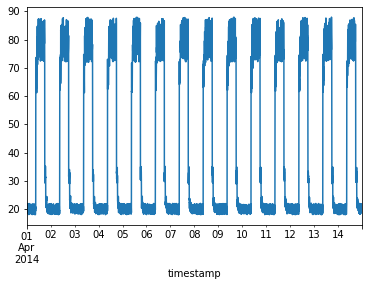

In [40]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

Timeseries data with anomalies

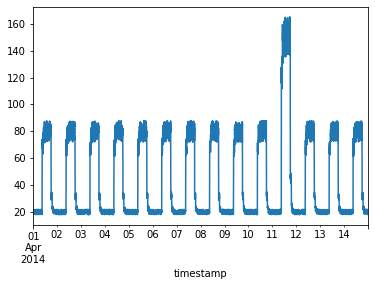

In [41]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

Prepare training data

In [42]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [43]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


Build a model

In [44]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout_5 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_6 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            

Train the model

In [45]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 6s 20ms/step - loss: 0.5192 - val_loss: 0.0729
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0791 - val_loss: 0.0410
Epoch 3/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0558 - val_loss: 0.0359
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0480 - val_loss: 0.0311
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0418 - val_loss: 0.0278
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0371 - val_loss: 0.0246
Epoch 7/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0336 - val_loss: 0.0226
Epoch 8/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0213
Epoch 9/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0284 - val_loss: 0.0193
Epoch 10/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0266 - val_loss: 0.0196
Epoch 11/50
27/27 

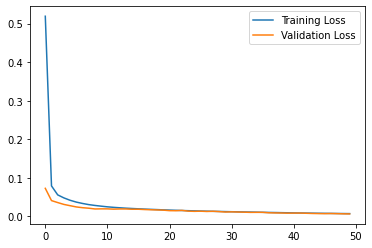

In [46]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Detecting anomalies

118/118 [==============================] - 1s 5ms/step


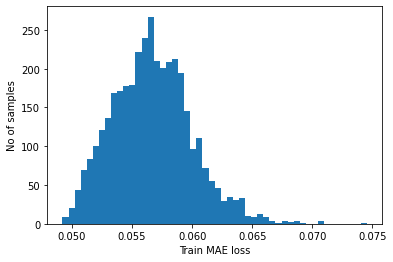

Reconstruction error threshold:  0.0745333851052325


In [47]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

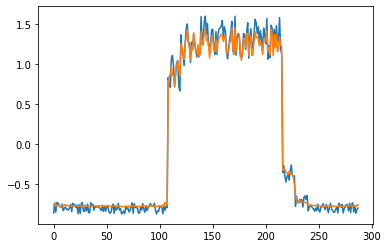

In [48]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

Prepare test data

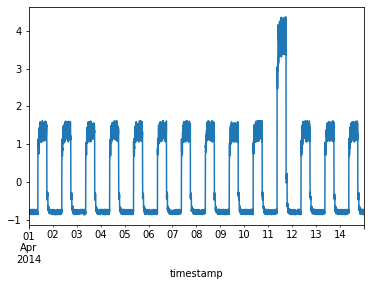

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 0s 2ms/step


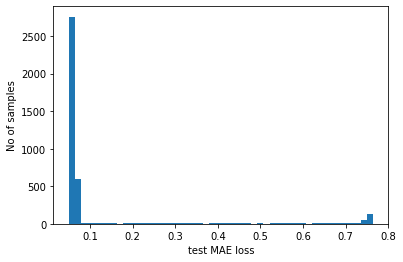

Number of anomaly samples:  399
Indices of anomaly samples:  (array([ 793, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2

In [49]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Plot anomalies

In [50]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

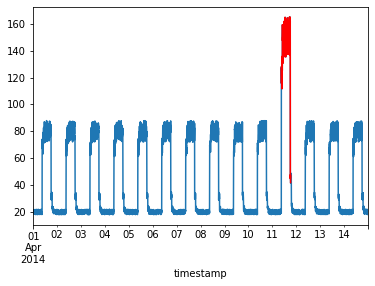

In [51]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

##miniGPT Example
Text from the IMDB sentiment classification dataset for training and generate new movie reviews for a given prompt. Note: atleast 1 mil. words needed.

**Tokenizer Example**
https://platform.openai.com/tokenizer

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import os
import re
import string
import random

Define Layers

In [2]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
Create GPT model

In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

Get the data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

Build dataset

In [ ]:
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf.data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

Implement a Keras callback for generating text

In [8]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [ ]:
model = create_model()

model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])